# More on Spam filtering using Naive Bayes

In [1]:
import numpy as np

data = np.load('data/lingspam/lingspam.npz')

In [2]:
from collections import Counter, OrderedDict

# create a dictionary with each word as the key and the number of occurences as the value
cnt = Counter()
total_words = 0
for entry in data['words']:
    total_words += len(entry)    # total number of words in the dataset
    for word in entry:
        cnt[word] += 1

# order the previous dictionary by most common words
ordered_cnt = OrderedDict(cnt.most_common())

In [3]:
num_words_threshold = 9451

In [4]:
unique_words_90 = list(OrderedDict(cnt.most_common(num_words_threshold)).keys())

In [5]:
def create_feature(list):
    
    # list with words from list which are in the unique_words_90 list
    words_in_unique_list = [word for word in list if word in unique_words_90]
    
    # dictionary created from previous list counting the number of occurences
    words_in_unique_dict = Counter(words_in_unique_list)
    
    # array of zeros, with the same number of elements as the unique_words_90 list
    features = np.zeros(len(unique_words_90), dtype=np.uint32)
    
    # for each word:occurence in dictionary, save occurence in the correct slot of features
    for word, occurence in words_in_unique_dict.items():
        features[unique_words_90.index(word)] = occurence
    
    return features

In [6]:
# creates a matrix of zeros with dimensions of (number of targets)x(number of unique words)
X = np.empty((len(data['targets']), len(unique_words_90)), dtype=np.uint32)

# use function create_feature for each row
for i, email in enumerate(data['words']):
    X[i,:] = create_feature(email)

In [7]:
y = data['targets']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (2025, 9451)
X_test:  (868, 9451)
y_train:  (2025,)
y_test:  (868,)


In [9]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [10]:
from sklearn.metrics import confusion_matrix

y_pred = nb.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[724   7]
 [  1 136]]


In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       1.00      0.99      0.99       731
       True       0.95      0.99      0.97       137

avg / total       0.99      0.99      0.99       868



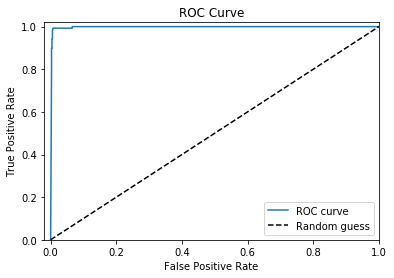

In [12]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

y_pred_prob = nb.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [13]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred_prob) 

0.9977033760372253

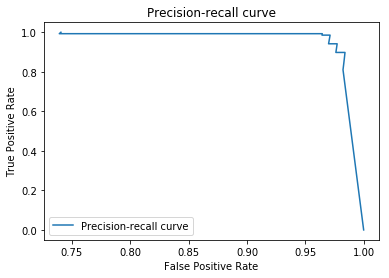

In [14]:
from sklearn.metrics import precision_recall_curve 

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Precision-recall curve')
_ = plt.legend(loc="lower left")